In [1]:
import sys
sys.path.append("../")
sys.path.append("../../../assets/diffusion")

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
import pandas as pd
import pickle

from experiments import RandomWalkDiffusionExperiment
from models import RandomWalkDiffusion

/Users/lukas/opt/miniconda3/envs/bfPower/lib/python3.10/site-packages/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# If set to False, existing results will be loaded
# Set to True if you want to re-run the experiments
SIMULATE_DATA = False
TRAIN_NETWORKS = False

In [3]:
PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
PARAM_NAMES  = [r'$v$', r'$a$', r'$\tau$']

FONT_SIZE_1 = 20
FONT_SIZE_2 = 18
FONT_SIZE_1 = 16

In [4]:
random_walk_ddm = RandomWalkDiffusion()
experiment = RandomWalkDiffusionExperiment(random_walk_ddm)

INFO:root:Performing 2 pilot runs with the random_walk_diffusion_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1320, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1320)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 1320, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from ../../optimal_policy/checkpoints/optimal_policy/history_50.pkl.
INFO:root:Networks loaded from ../../optimal_policy/checkpoints/optimal_policy/ckpt-50
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


## Simulation

In [5]:
if SIMULATE_DATA:
    from models import StaticDiffusion, StationaryDiffusion, RegimeSwitchingDiffusion
    static_ddm = StaticDiffusion()
    stationary_ddm = StationaryDiffusion()
    regime_switching_ddm = RegimeSwitchingDiffusion()

    static_ddm_sim = static_ddm.generate(200)
    stationary_ddm_sim = stationary_ddm.generate(200)
    random_walk_ddm_sim = random_walk_ddm.generate(200)
    regime_switching_ddm_sim = regime_switching_ddm.generate(200)
    with open('../data/static_ddm_sim_200.pkl', 'wb') as f:
        pickle.dump(static_ddm_sim, f)
    with open('../data/stationary_ddm_sim_200.pkl', 'wb') as f:
        pickle.dump(stationary_ddm_sim, f)
    with open('../data/random_walk_ddm_sim_200.pkl', 'wb') as f:
        pickle.dump(random_walk_ddm_sim, f)
    with open('../data/regime_switching_ddm_sim_200.pkl', 'wb') as f:
        pickle.dump(regime_switching_ddm_sim, f)
else:
    with open('../data/static_ddm_sim_200.pkl', 'rb') as f:
        static_ddm_sim = pickle.load(f)
    with open('../data/stationary_ddm_sim_200.pkl', 'rb') as f:
        stationary_ddm_sim = pickle.load(f)
    with open('../data/random_walk_ddm_sim_200.pkl', 'rb') as f:
        random_walk_ddm_sim = pickle.load(f)
    with open('../data/regime_switching_ddm_sim_200.pkl', 'rb') as f:
        regime_switching_ddm_sim = pickle.load(f)

## Training

In [7]:
if TRAIN_NETWORKS:
    history = experiment.run(
        epochs=50, 
        iterations_per_epoch=1000, 
        batch_size=8
    )
else:
    history = experiment.trainer.loss_history.get_plottable()

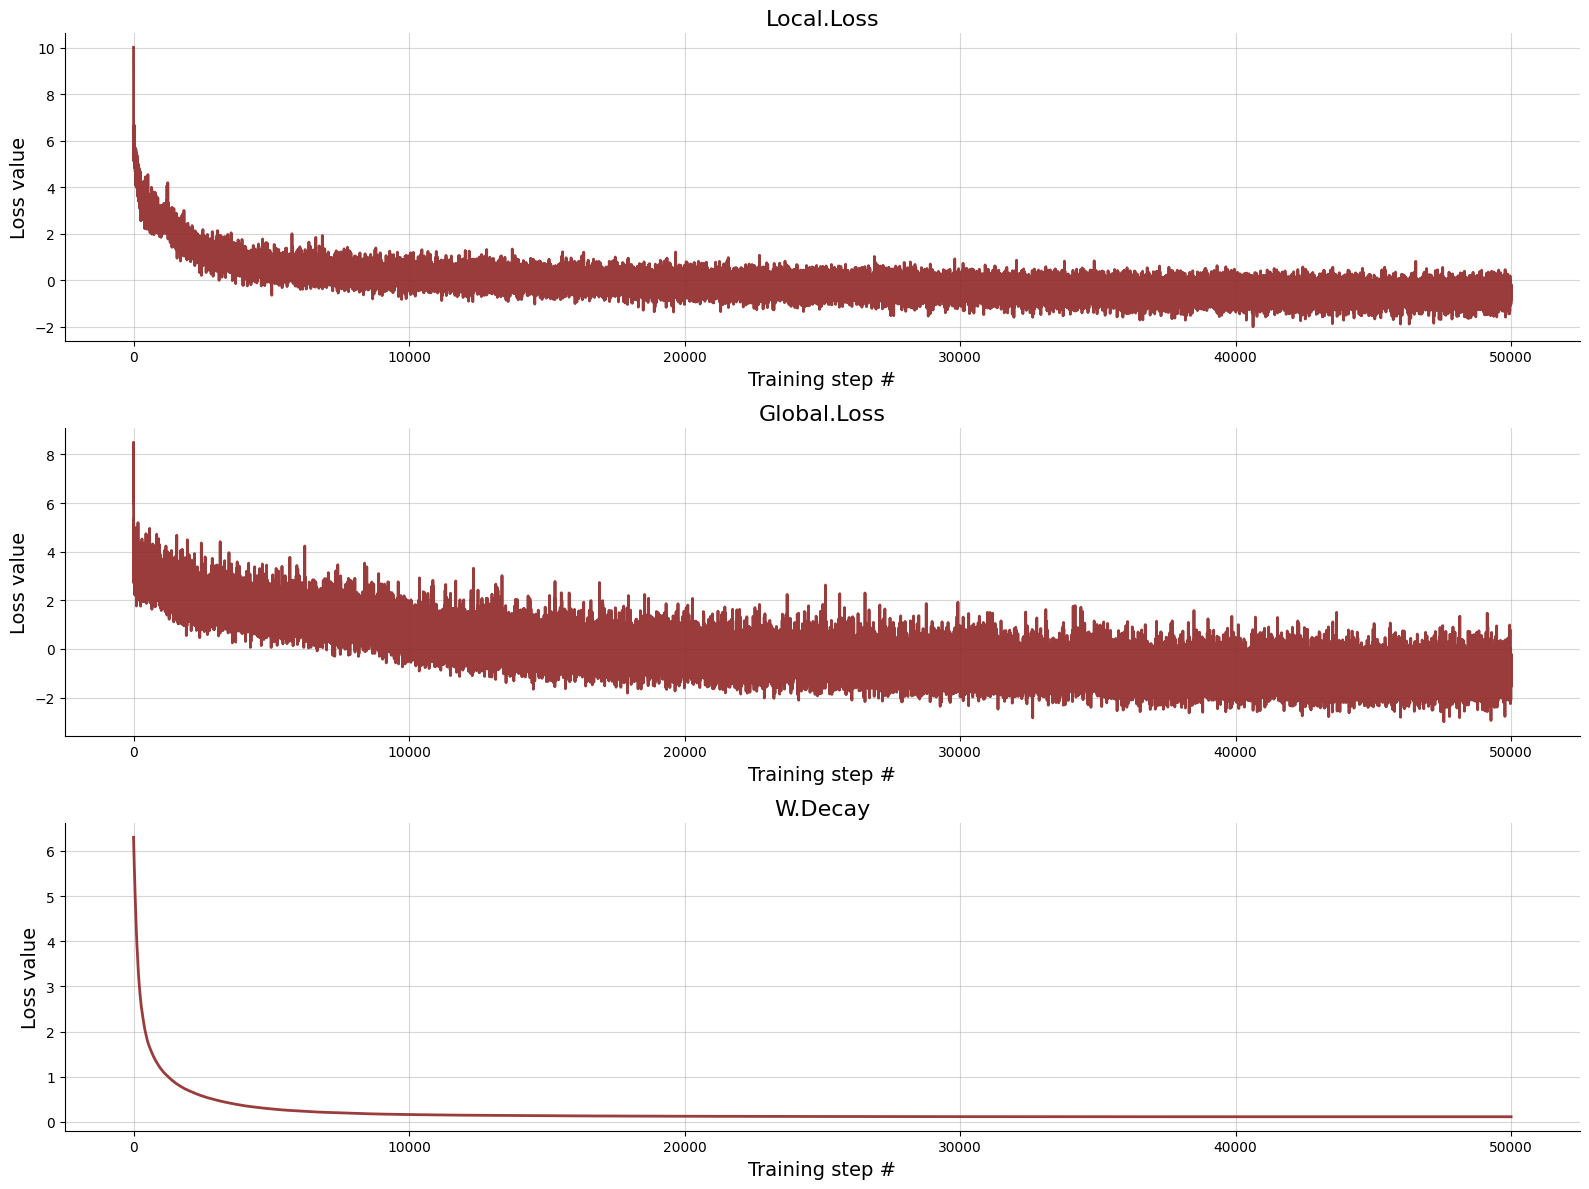

In [8]:
f = beef.diagnostics.plot_losses(history)

## Evaluation

In [17]:
%%time
post_samples = experiment.amortizer.sample(
    {'summary_conditions': regime_switching_ddm_sim['sim_data'][:1, :, None]},
    1000
    )

CPU times: user 21.3 s, sys: 9.75 s, total: 31.1 s
Wall time: 5.74 s


In [27]:
post_samples_not_z = post_samples['local_samples'] * random_walk_ddm.local_prior_stds + random_walk_ddm.local_prior_means
post_means = post_samples_not_z.mean(axis=1)
post_stds = post_samples_not_z.std(axis=1)

In [28]:
true_params = regime_switching_ddm_sim['prior_draws'][0]

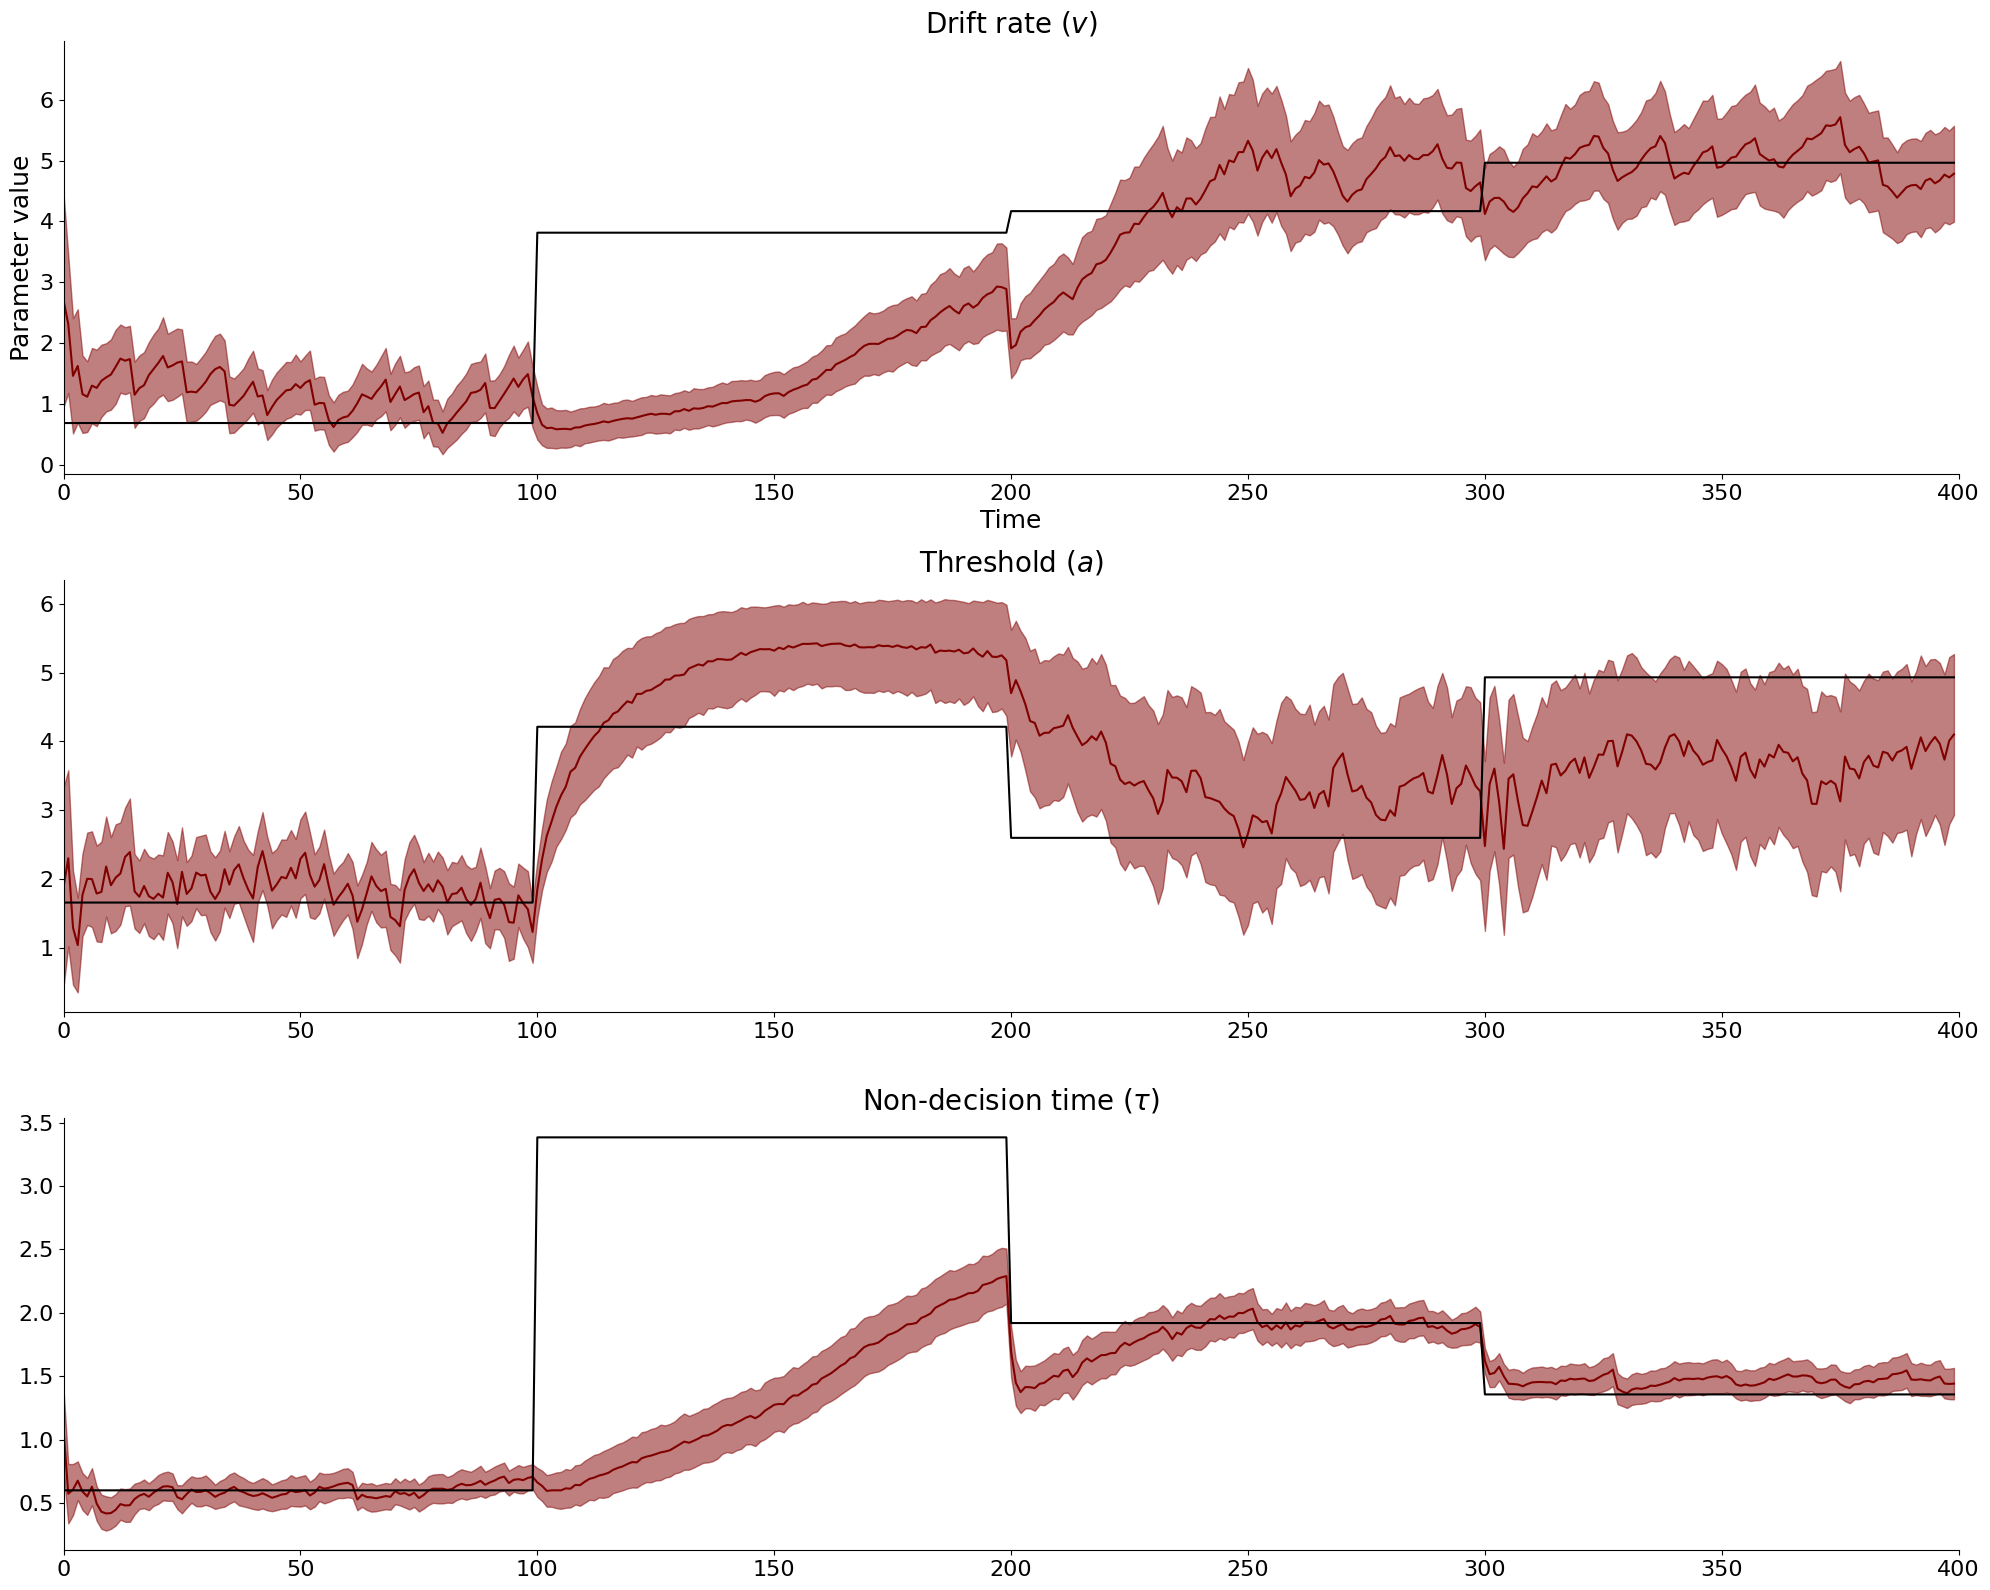

In [29]:
f, axarr = plt.subplots(3, 1, figsize=(20, 16))
for i, ax in enumerate(axarr.flat):
    ax.plot(
        np.arange(post_means.shape[0]), post_means[:, i],
        color = "maroon"
    )
    ax.fill_between(
        np.arange(post_means.shape[0]),
        post_means[:, i] - post_stds[:, i],
        post_means[:, i] + post_stds[:, i],
        alpha = 0.5,
        color = "maroon"
    )

    ax.plot(
        np.arange(true_params.shape[0]), true_params[:, i],
        color = "black"
    )

    ax.set_xlim([0, post_means.shape[0]])
    ax.set_title(PARAM_LABELS[i] + ' ({})'.format(PARAM_NAMES[i]), fontsize=20)
    if i == 0:
        ax.set_xlabel('Time', fontsize=18)
        ax.set_ylabel("Parameter value", fontsize=18)

    ax.set_title(PARAM_LABELS[i] + ' ({})'.format(PARAM_NAMES[i]), fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
sns.despine()
f.tight_layout()

In [ ]:
# post_samples = np.zeros((N_SUBS, N_OBS, N_SAMPLES, 3))
# with tf.device('/cpu:0'):
#     for i in range(N_SUBS):
#         tmp_data = {'summary_conditions': emp_data[i:i+1]}
#         samples = amortizer.sample(tmp_data, N_SAMPLES)
#         post_samples[i] = samples['local_samples']

# post_samples.shape